## Getting started with pyForMetrics

First, we install required packages:

In [4]:
!python -m pip install pyForMetrix laspy rioxarray wget matplotlib

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=50d1461c8384ac3ff8f79997543b903c76e969fce5bc32c44b82a85f330f7afe
  Stored in directory: c:\users\lukas\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Then, we need a point cloud dataset. You can use your own or download a sample dataset from the City of Vancouver [(Open Data)](https://opendata.vancouver.ca/explore/dataset/lidar-2018/):


In [6]:
!python -m wget https://webtransfer.vancouver.ca/opendata/2018LiDAR/4830E_54560N.zip 4830E_54560N.zip
!python -m zipfile -e 4830E_54560N.zip .


Saved under 4830E_54560N.zip


We need to read in the point cloud into a numpy array. Depending on the metrics we will derive later, different attributes also have to be loaded in. In this example, the 3D point cloud along with classification and echo number information is required. For reading in the file, we use `laspy`. To keep memory below 2GB, we subsample the point cloud upon reading.

In [8]:
import numpy as np
import laspy

s = 3000

inFile = laspy.read(r"4830E_54560N.las")
coords = np.vstack([inFile.x[::s],
                    inFile.y[::s],
                    inFile.z[::s]]).transpose()
points = {
    'points': coords[::s],
    'echo_number': inFile.return_number[::s],
    'classification': inFile.classification[::s]
}

After importing the package `pyForMetrics`, we can create a `RasterMetrics` or a `PlotMetrics` object, depending on
the application. Let's first work with `RasterMetrics`, which will calculate the set of metrics for each cell of a
raster overlaid on the point cloud data.

In [9]:
from pyForMetrix.metrix import RasterMetrics
rm = RasterMetrics(points, raster_size=25)

The code above may take some time to run, as on the creation of the`RasterMetrics` object, the point cloud is rasterized
to the final cells. The runtime will increase with more points and a smaller raster size.

We then select which metrics we want to calculate. `pyForMetrix` comes with a number of predefined metrics, convieniently grouped in two collections: `publications`, where metrics from different publications in the literature are taken, and `types`, which groups metrics by their type. Later, we will see how to create your own metric calculators. For now, we will use the ones presented by Woods et al. (2009):


In [10]:
from pyForMetrix.metricCalculators.publications import MCalc_Woods_et_al_2009
mc = MCalc_Woods_et_al_2009()
metrics = rm.calc_custom_metrics(metrics=mc)


With the last line, we created an [`xarray`](https://docs.xarray.dev/en/stable/)`.DataArray` object containing the metrics for each pixel:


In [11]:
print(metrics)

<xarray.DataArray (y: 40, x: 40, val: 26)>
array([[[ 8.89500000e+01,  8.90200000e+01,  8.90700000e+01, ...,
          3.68335834e+00,  7.01144926e-01,  2.27517370e-01],
        [ 8.89300000e+01,  9.17100000e+01,  9.63400000e+01, ...,
          5.82563263e-01,  5.32337210e-01,  4.13955542e-01],
        [ 9.60300000e+01,  1.02950000e+02,  1.11197000e+02, ...,
         -1.95949508e-01,  4.53641988e-01,  4.48952305e-01],
        ...,
        [ 9.25090000e+01,  1.08470000e+02,  1.12550000e+02, ...,
          2.28676927e+00,  4.67347898e-01,  4.64552502e-01],
        [ 8.41600000e+01,  1.19140000e+02,  1.21410000e+02, ...,
          2.54644842e+00,  5.05866552e-01,  5.01203720e-01],
        [ 8.68360000e+01,  1.20400000e+02,  1.22620000e+02, ...,
          2.98616310e+00,  4.79139806e-01,  4.74055514e-01]],

       [[ 8.92000000e+01,  8.92500000e+01,  8.93100000e+01, ...,
          2.91807758e+01,  9.37620045e-01,  6.62214074e-02],
        [ 8.91300000e+01,  8.91700000e+01,  8.92200000e+01, 


Using [`rioxarray`](https://corteva.github.io/rioxarray/stable/), we can save the values (here: the `p90` metric, i.e., the 90th height percentile) to a raster file:


In [12]:
import rioxarray
metrics.sel(val='p90').rio.to_raster(f"p90.tif", "COG")

We can also plot our results:

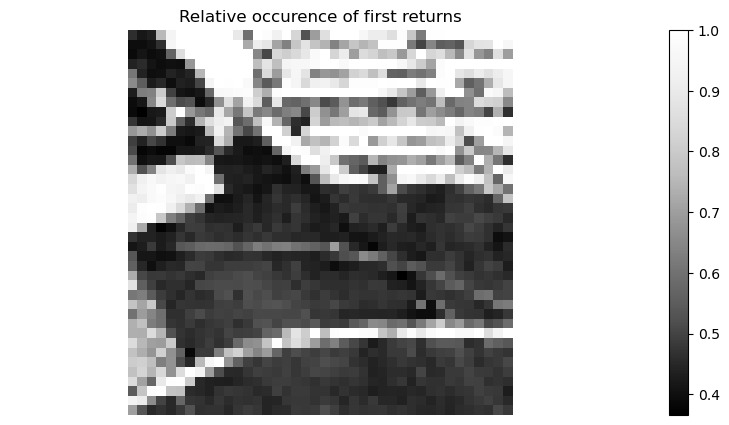

In [21]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
metrics.sel(val='p_first_returns').plot(cmap="Greys_r",
                 ax=ax)
ax.set_title("Relative occurence of first returns")
ax.axis('equal')
ax.set_axis_off()
plt.show()

And, similarly, we can plot all metrics:

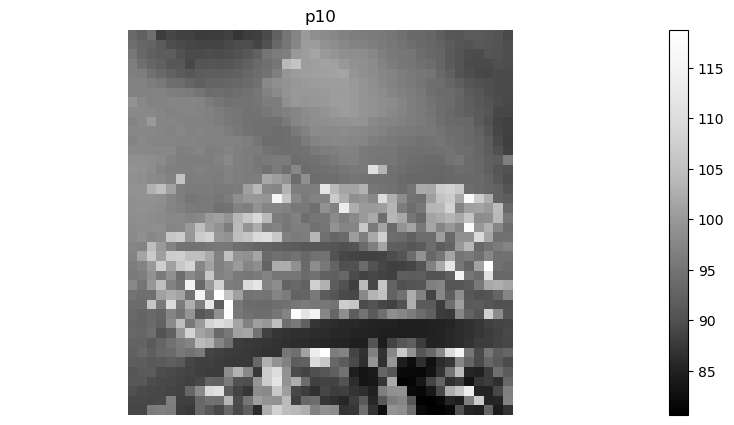

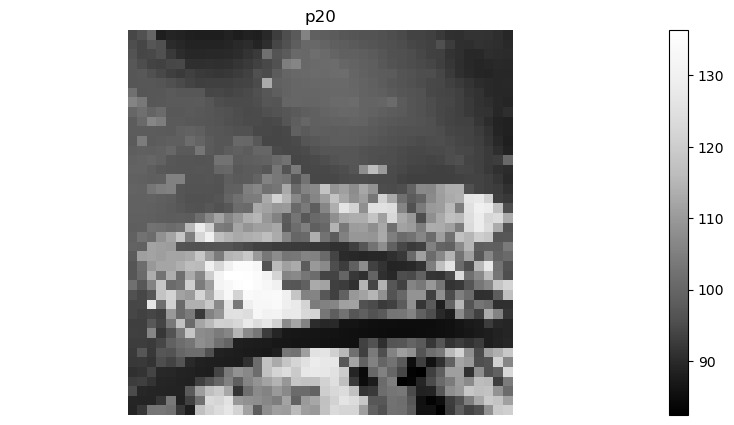

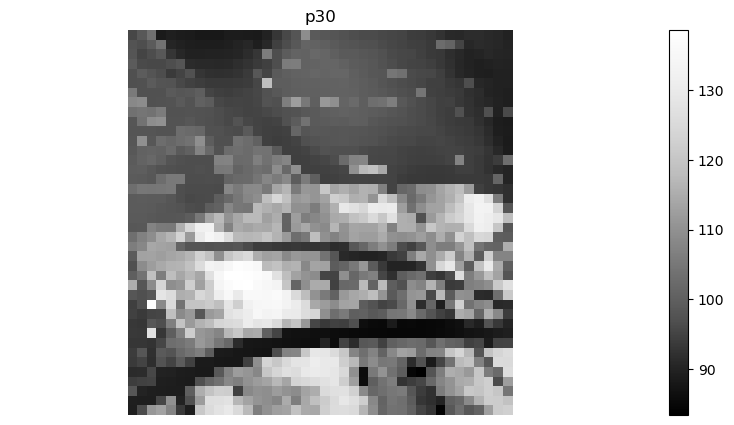

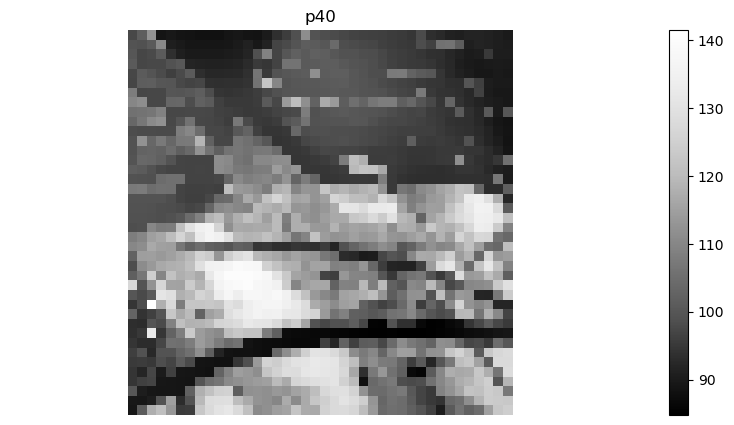

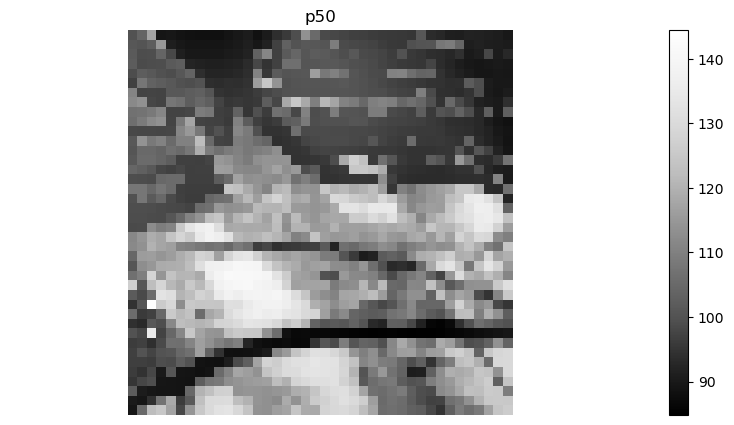

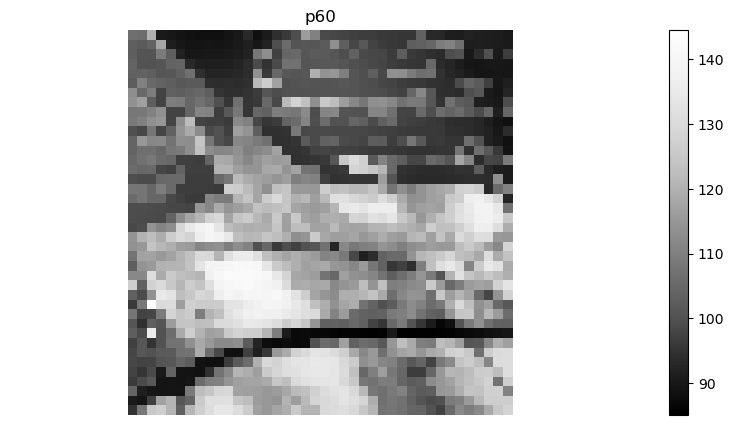

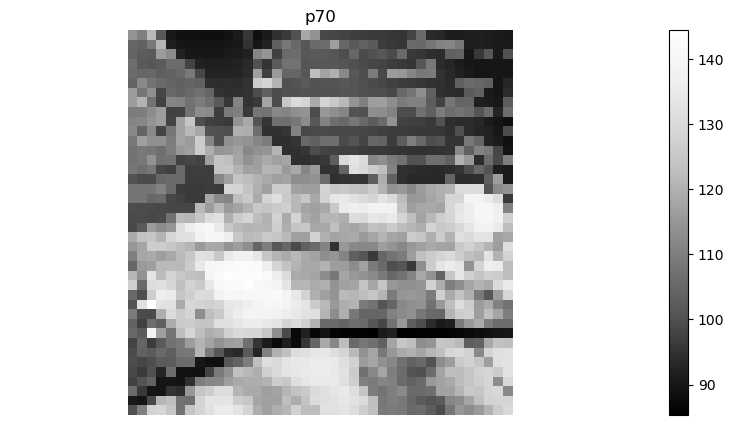

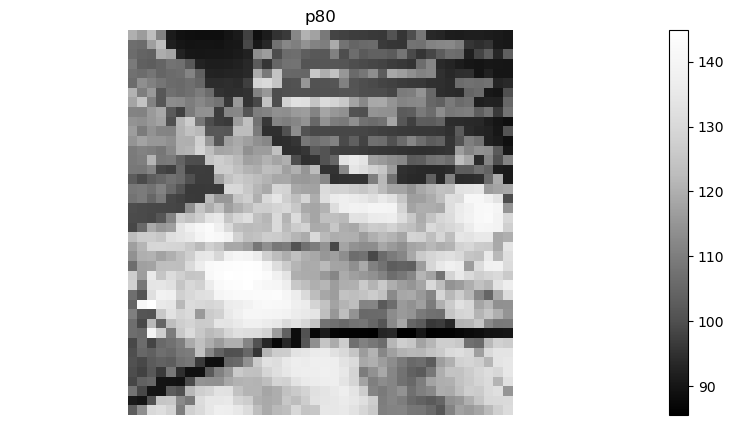

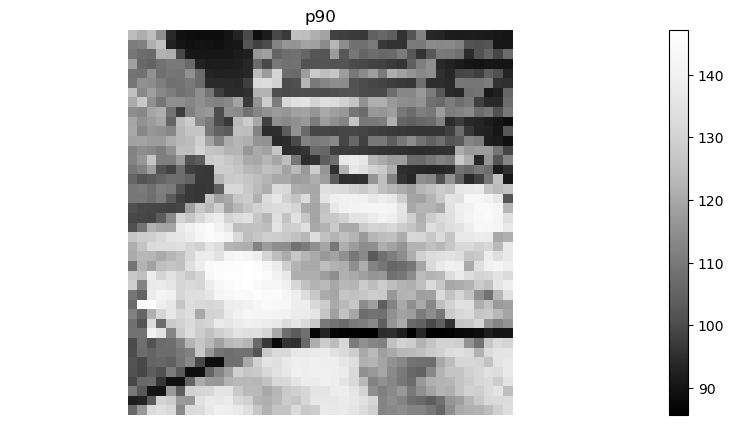

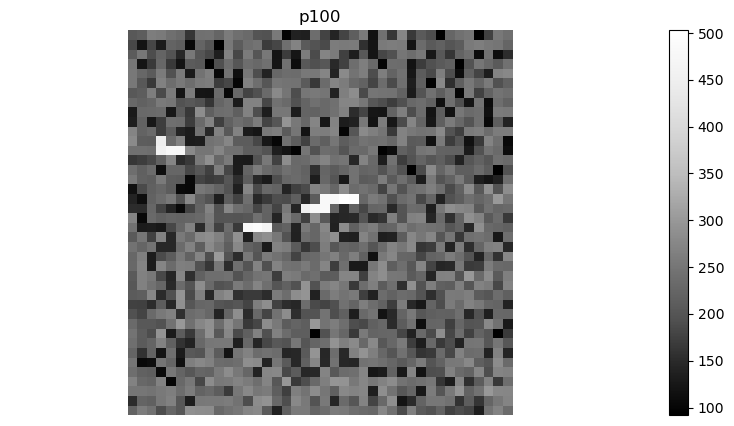

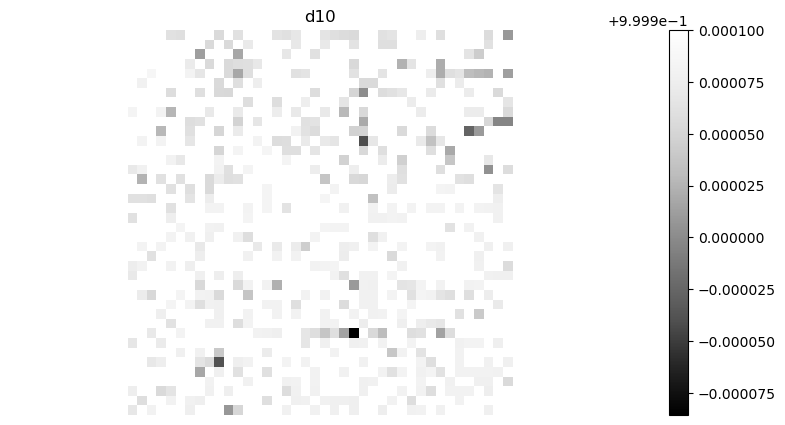

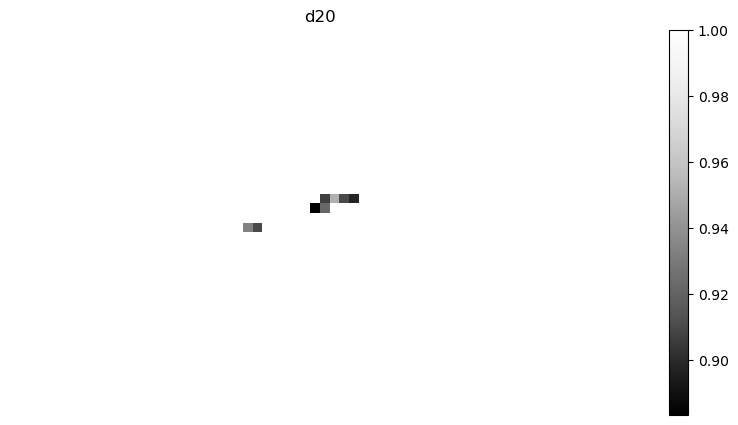

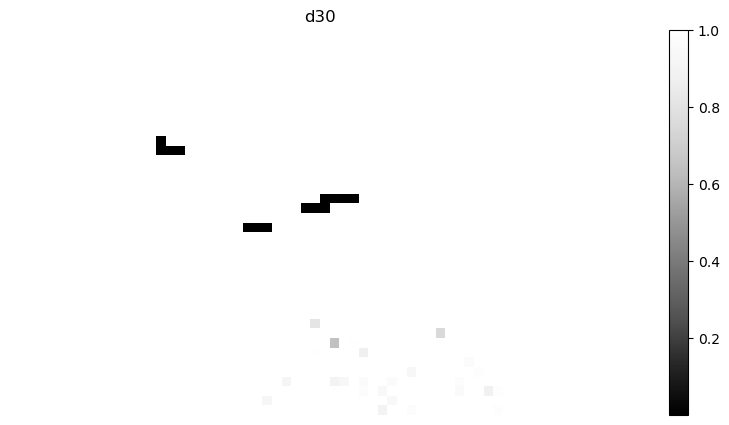

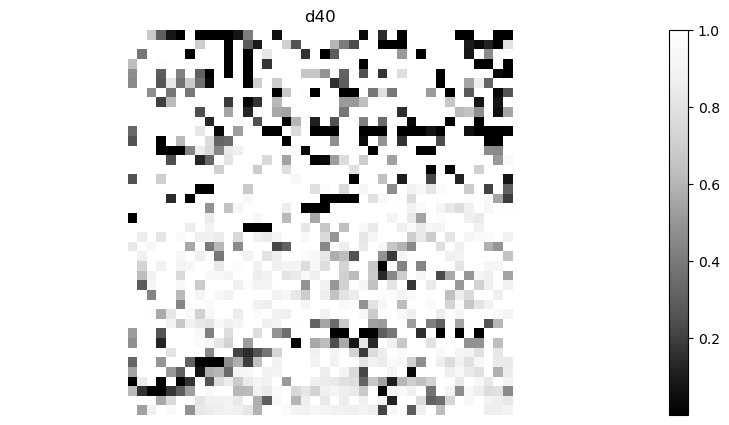

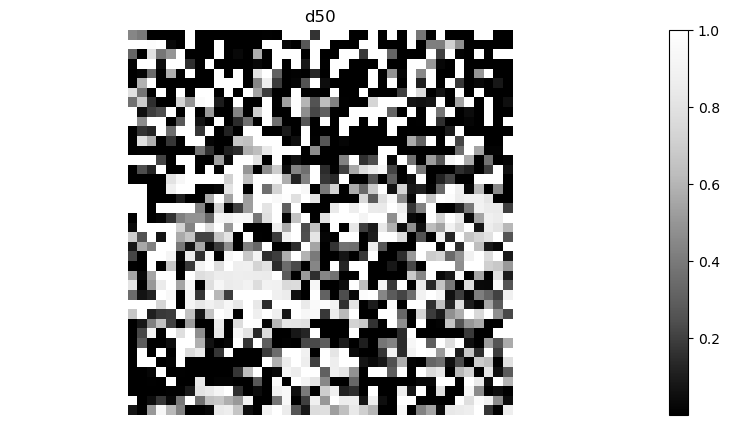

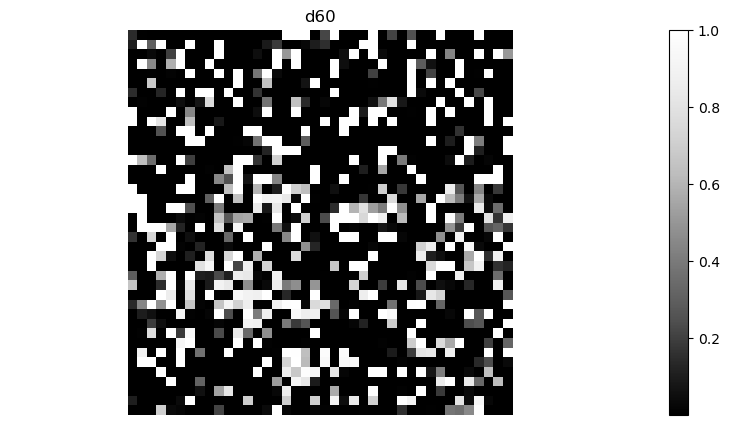

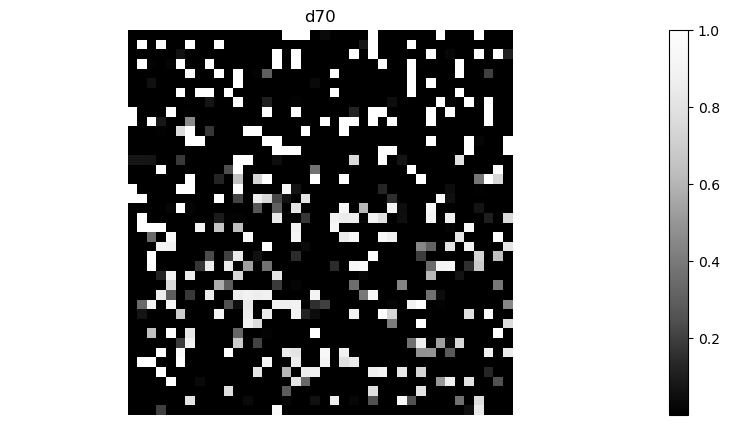

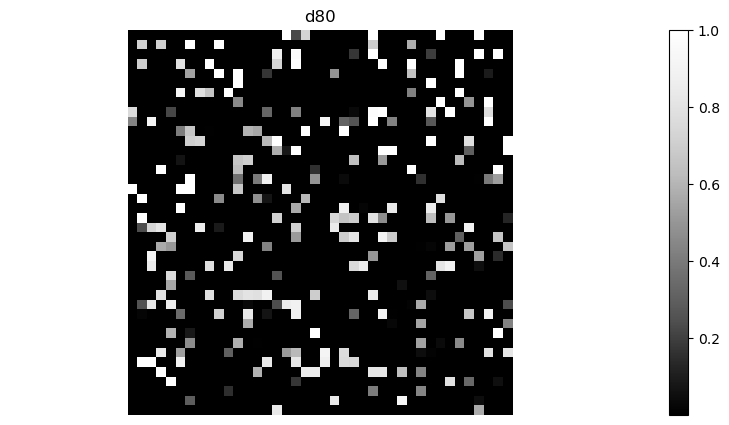

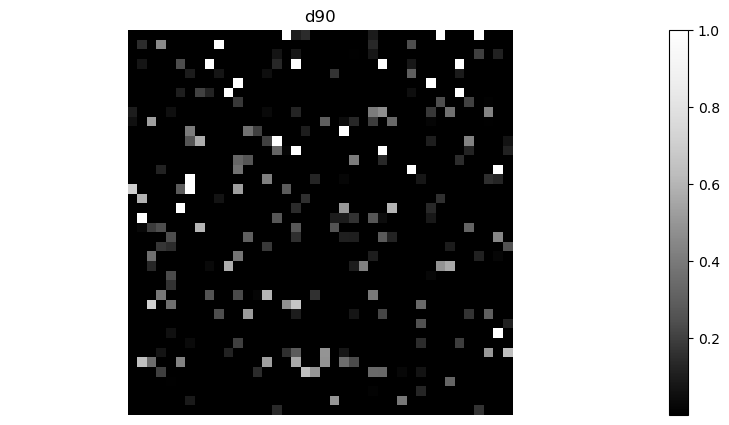

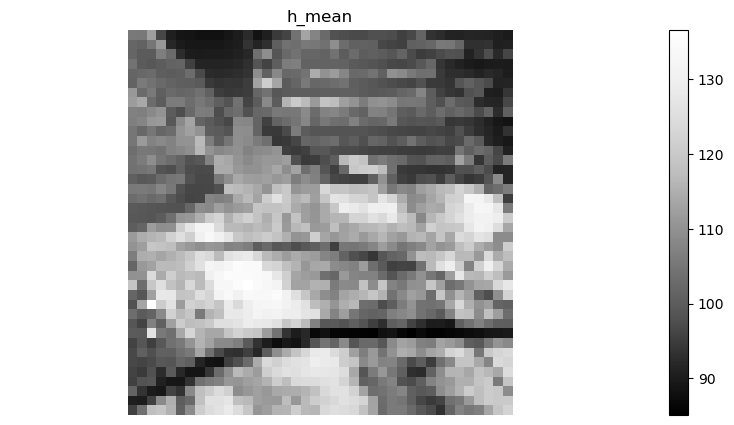

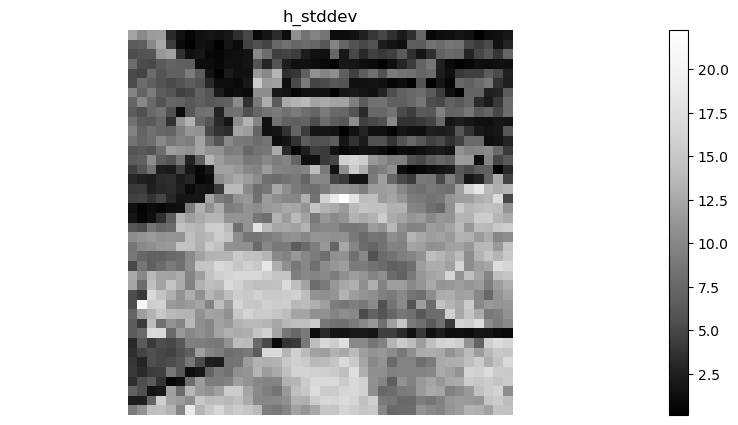

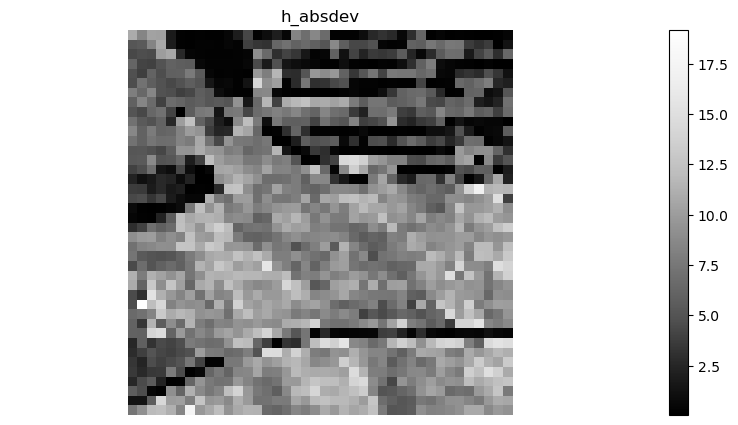

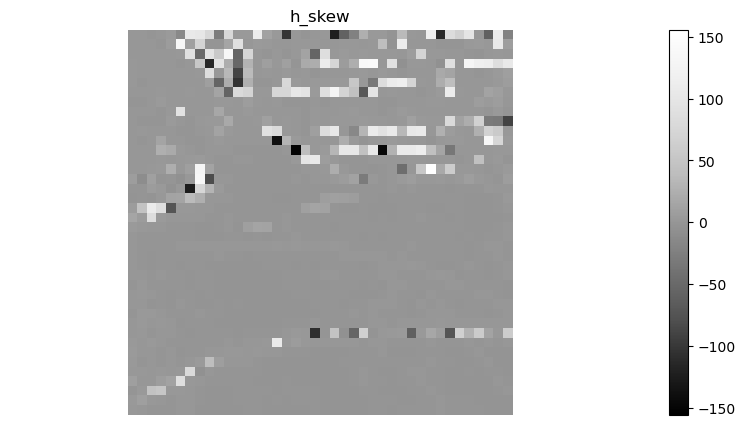

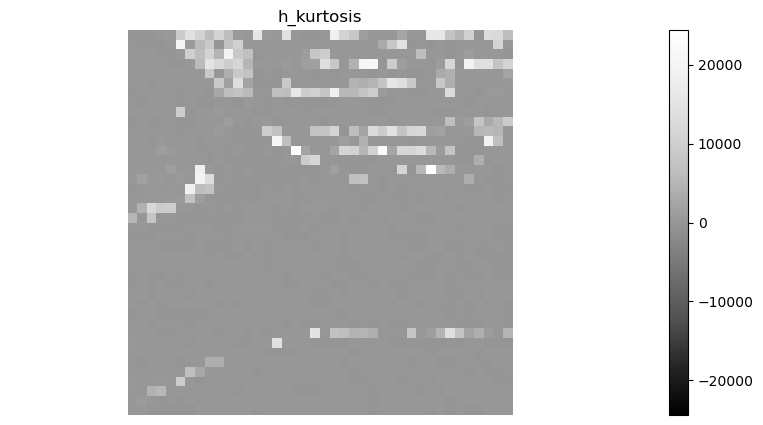

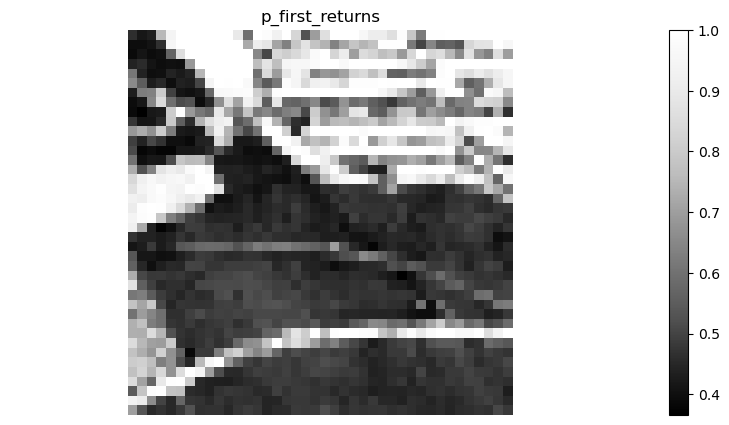

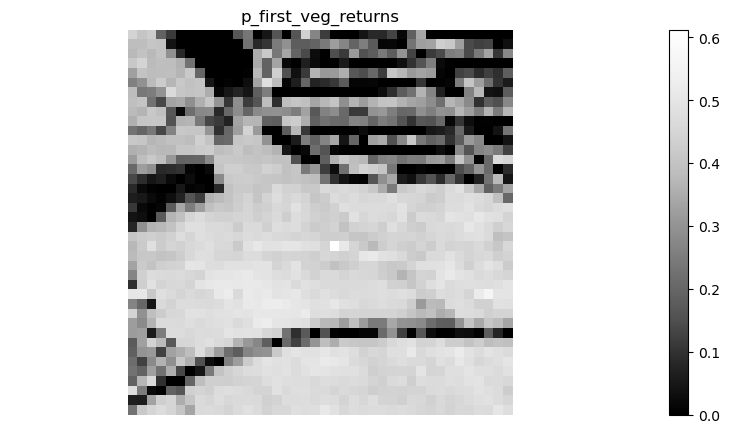

In [23]:
for m in metrics.val.data:
    f, ax = plt.subplots(figsize=(10, 5))
    metrics.sel(val=m).plot(cmap="Greys_r",
                     ax=ax)
    ax.set_title(m)
    ax.axis('equal')
    ax.set_axis_off()
    plt.show()